In [1]:
import pandas as pd
import numpy as np

from os.path import exists
from os import mkdir

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import open3d as o3d
from utils import *

#%env OPEN3D_CPU_RENDERING true

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

PLOTDIR = "plots"
DATADIR = "data"

DIRS = [PLOTDIR, DATADIR]

def plot_savepath(filename):
    return PLOTDIR + f"/{filename}"

def data_path(filename):
    return DATADIR + f"/{filename}"

for d in DIRS:
    if not exists(d):
        mkdir(d)
              
output_dir = f"figures/experiments/"

In [2]:
Organoid_Names = ['KCL_1_MAP2.xls',
                  'KCL_2_MAP2.xls',
                  'KCL_3_MAP2.xls',
                  'K562_1_MAP2.xls', 
                  'K562_2_MAP2.xls',
                  'K562_3_MAP2.xls',
                  'BCRABL_PDX_1_MAP2.xls',
                  'BCRABL_PDX_2_MAP2.xls', 
                  'BCRABL_PDX_3_MAP2.xls',
                  'VOL_1857_1.xls',
                  'VOL_1857_2.xls', 
                  'VOL_1857_3.xls',
                  ]

organoid_pts = []

for name in Organoid_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    organoid_pts.append(pts)

In [3]:
Entity_Names = ['KCL_1_CFSE.xls',
                'KCL_2_CFSE.xls',
                'KCL_3_CFSE.xls',
                'K562_1_CFSE.xls', 
                'K562_2_CFSE.xls',
                'K562_3_CFSE.xls',
                'BCRABL_PDX_1_CFSE.xls',
                'BCRABL_PDX_2_CFSE.xls', 
                'BCRABL_PDX_3_CFSE.xls',
                'DOTS_1857_1.xls',
                'DOTS_1857_2.xls', 
                'DOTS_1857_3.xls',
                ]

entity_pts = []

for name in Entity_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    entity_pts.append(pts)

In [4]:
assert len(organoid_pts)==len(entity_pts)

distances = []

for index in range(len(organoid_pts)):
    # Organoids
    pcd_org = o3d.geometry.PointCloud()
    pcd_org.points = o3d.utility.Vector3dVector(organoid_pts[index])
    pcd_org.compute_convex_hull()
    pcd_org.estimate_normals()
    pcd_org.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_org, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_org, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_org.paint_uniform_color([0.8, 0.2, 0])
    mesh_org.compute_vertex_normals()
    mesh_org.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_org = o3d.t.geometry.TriangleMesh.from_legacy(mesh_org)
    mesh_to_fill_org.fill_holes(hole_size=10)
    final_mesh_org = mesh_to_fill_org.to_legacy()
    
    # Entities
    pcd_ent = o3d.geometry.PointCloud()
    pcd_ent.points = o3d.utility.Vector3dVector(entity_pts[index])
    pcd_ent.compute_convex_hull()
    pcd_ent.estimate_normals()
    pcd_ent.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_ent, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_ent, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_ent.paint_uniform_color([0.8, 0.2, 0])
    mesh_ent.compute_vertex_normals()
    mesh_ent.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_ent = o3d.t.geometry.TriangleMesh.from_legacy(mesh_ent)
    mesh_to_fill_ent.fill_holes(hole_size=10)
    final_mesh_ent = mesh_to_fill_ent.to_legacy()
    
    # Calculation of distances
    mesh_org_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_org)
    mesh_ent_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_ent)
    
    scene = o3d.t.geometry.RaycastingScene()
    mesh_ids = {}
    mesh_ids[scene.add_triangles(mesh_org_toleg)] = 'surface'
    mesh_ids[scene.add_triangles(mesh_ent_toleg)] = 'cells'

    query_point = np.asarray(entity_pts[index]).astype('float32')

    unsigned_distance = scene.compute_distance(query_point)
    distances.append(unsigned_distance.numpy())

[Open3D DEBUG] Input Points / Samples: 4731 / 4490
[Open3D DEBUG] #   Got kernel density: 0.00242400 (s), 348.184 (MB) / 348.184 (MB) / 348 (MB)
[Open3D DEBUG] #     Got normal field: 0.0156262 (s), 350.387 (MB) / 350.387 (MB) / 350 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 5.143069e-06 / 2.433186e-02
[Open3D DEBUG] #       Finalized tree: 0.0261981 (s), 356.453 (MB) / 356.453 (MB) / 356 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0408702 (s), 356.641 (MB) / 356.641 (MB) / 356 (MB)
[Open3D DEBUG] #Set point constraints: 0.00307012 (s), 356.875 (MB) / 356.875 (MB) / 356 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 140085 / 149176 / 10921
[Open3D DEBUG] Memory Usage: 356.875 MB
[Open3D DEBUG] # Linear system solved: 0.226255 (s), 364.195 (MB) / 364.195 (MB) / 364 (MB)
[Open3D DEBUG] Got average: 0.00515604 (s), 364.688 (MB) / 364.688 (MB) / 364 (MB)
[Open3D DEBUG] Iso-Value: 5.192968e-01 = 2.456793e+03 / 4.731000e+03
[Open3D DEBUG] #          Total Solve:      

MB)	Nodes: 35937
          GS: 2.0773e-01 -> 2.0773e-01 -> 2.7891e-03 (1.3e-02) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.001	(360.293 MB)	Nodes: 3008
            GS: 2.1465e-01 -> 2.1465e-01 -> 5.9325e-04 (2.8e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.002	(360.316 MB)	Nodes: 4688
              GS: 1.7038e-01 -> 1.7038e-01 -> 1.1107e-03 (6.5e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.004 /  0.013	(360.535 MB)	Nodes: 12600
                GS: 1.1957e-01 -> 1.1957e-01 -> 7.3470e-04 (6.1e-03) [8]
Cycle[0] Depth[ 9/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.009 /  0.030	(363.492 MB)	Nodes: 27656
                  GS: 6.7684e-02 -> 6.7684e-02 -> 3.9239e-04 (5.8e-03) [8]
Cycle[0] Depth[10/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.013 /  0.046	(364.195 MB)	Nodes: 34336
                    GS: 4.2420

[Open3D DEBUG] #     Got normal field: 0.022656 (s), 483.078 (MB) / 483.078 (MB) / 483 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 2.801794e-06 / 2.306157e-02
[Open3D DEBUG] #       Finalized tree: 0.029166 (s), 483.078 (MB) / 483.078 (MB) / 483 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0460880 (s), 483.078 (MB) / 483.078 (MB) / 483 (MB)
[Open3D DEBUG] #Set point constraints: 0.00422311 (s), 483.078 (MB) / 483.078 (MB) / 483 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 166440 / 186272 / 3945
[Open3D DEBUG] Memory Usage: 483.078 MB
[Open3D DEBUG] # Linear system solved: 0.200357 (s), 485.504 (MB) / 485.504 (MB) / 485 (MB)
[Open3D DEBUG] Got average: 0.00269389 (s), 485.512 (MB) / 485.512 (MB) / 485 (MB)
[Open3D DEBUG] Iso-Value: 5.158018e-01 = 4.245564e+03 / 8.231000e+03
[Open3D DEBUG] #          Total Solve:       1.3 (s),     491.9 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Sample

        GS: 6.8585e-02 -> 6.8585e-02 -> 5.5395e-04 (8.1e-03) [8]
Cycle[0] Depth[ 5/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.012 /  0.024	(462.539 MB)	Nodes: 35937
          GS: 6.0227e-02 -> 6.0227e-02 -> 6.3288e-04 (1.1e-02) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.001	(462.539 MB)	Nodes: 2424
            GS: 6.7312e-02 -> 6.7312e-02 -> 3.4660e-04 (5.1e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.002	(462.539 MB)	Nodes: 3312
              GS: 5.4655e-02 -> 5.4655e-02 -> 1.4907e-04 (2.7e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.002 /  0.003	(462.543 MB)	Nodes: 4848
                GS: 4.1681e-02 -> 4.1681e-02 -> 1.0530e-04 (2.5e-03) [8]
Cycle[0] Depth[ 9/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.003 /  0.004	(462.543 MB)	Nodes: 4720
                  GS: 3.1879e-02 -> 3.1879e-02 -> 4.8428e-0

[Open3D DEBUG] Input Points / Samples: 23870 / 17460
[Open3D DEBUG] #   Got kernel density: 0.00338602 (s), 563.59 (MB) / 563.59 (MB) / 563 (MB)
[Open3D DEBUG] #     Got normal field: 0.0384581 (s), 563.59 (MB) / 563.59 (MB) / 563 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.253743e-06 / 2.992685e-02
[Open3D DEBUG] #       Finalized tree: 0.037926 (s), 563.59 (MB) / 563.59 (MB) / 563 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0549319 (s), 563.59 (MB) / 563.59 (MB) / 563 (MB)
[Open3D DEBUG] #Set point constraints: 0.00545597 (s), 563.59 (MB) / 563.59 (MB) / 563 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 217547 / 245072 / 3553
[Open3D DEBUG] Memory Usage: 563.590 MB
[Open3D DEBUG] # Linear system solved: 0.269223 (s), 563.59 (MB) / 563.59 (MB) / 563 (MB)
[Open3D DEBUG] Got average: 0.0104120 (s), 563.59 (MB) / 563.59 (MB) / 563 (MB)
[Open3D DEBUG] Iso-Value: 5.135061e-01 = 1.225739e+04 / 2.387000e+04
[Open3D DEBUG] #          Total Solve:       1.3 (s),     5

[Open3D DEBUG] #          Total Solve:       1.1 (s),     628.6 (MB)028 /  0.090	(533.953 MB)	Nodes: 104992
                    GS: 5.0734e-02 -> 5.0734e-02 -> 2.5419e-04 (5.0e-03) [8]
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(536.734 MB)	Nodes: 8
CG: 8.3784e-03 -> 8.3784e-03 -> 2.3507e-06 (2.8e-04) [32749]
Cycle[0] Depth[ 1/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(536.734 MB)	Nodes: 27
  GS: 4.0038e-02 -> 4.0038e-02 -> 3.4878e-04 (8.7e-03) [8]
Cycle[0] Depth[ 2/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(536.742 MB)	Nodes: 125
    GS: 6.3351e-02 -> 6.3351e-02 -> 8.9782e-04 (1.4e-02) [8]
Cycle[0] Depth[ 3/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.002 /  0.000	(536.758 MB)	Nodes: 729
      GS: 1.0929e-01 -> 1.0929e-01 -> 1.5870e-03 (1.5e-02) [8]
Cycle[0] Depth[ 4/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.003 /  0.001	(536.809

[Open3D DEBUG] # Linear system solved: 0.119865 (s), 639.281 (MB) / 639.281 (MB) / 639 (MB)
[Open3D DEBUG] Got average: 0.00197411 (s), 639.281 (MB) / 639.281 (MB) / 639 (MB)
[Open3D DEBUG] Iso-Value: 5.199863e-01 = 5.080266e+02 / 9.770000e+02
[Open3D DEBUG] #          Total Solve:       1.0 (s),     639.3 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 61113 / 22374
[Open3D DEBUG] #   Got kernel density: 0.00295901 (s), 698.379 (MB) / 698.379 (MB) / 698 (MB)
[Open3D DEBUG] #     Got normal field: 0.0330799 (s), 698.379 (MB) / 698.379 (MB) / 698 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 4.575903e-07 / 2.796472e-02
[Open3D DEBUG] #       Finalized tree: 0.0356581 (s), 698.379 (MB) / 698.379 (MB) / 698 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.056386 (s), 698.379 (MB) / 698.379 (MB) / 698 (MB)
[Open3D DEBUG] #Set point constraints: 0.00619698 (s), 698.379 (MB) / 698.379 (MB) / 698 (MB)
[Open3D

In [5]:
dict_keys = ['A', 'B', 'C', 'D', 'E', 'F', 'G',
             'H', 'I', 'J', 'K', 'L']

d = dict(zip(dict_keys, distances))

In [6]:
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
df = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
display(df)

,Entity,Distance to Surface (μm)
0,A,31.362188
1,A,9.945229
2,A,8.102470
3,A,2.096421
4,A,0.367877
...,...,...
21487,L,NaN
21488,L,NaN
21489,L,NaN
21490,L,NaN


In [7]:
df.loc[df['Entity'] == 'A', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'B', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'C', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'D', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'E', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'F', 'Types'] = 'Repeat 3'
df.loc[df['Entity'] == 'G', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'H', 'Types'] = 'Repeat 2'
df.loc[df['Entity'] == 'I', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'J', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'K', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'L', 'Types'] = 'Repeat 3'   

df['Entity'] = df['Entity'].replace({
              'A':'KCL22',
              'B':'KCL22',
              'C':'KCL22',
              'D':'K562',
              'E':'K562',
              'F':'K562',
              'G':'PDX3',
              'H':'PDX3',
              'I':'PDX3',
              'J':'PDX1',
              'K':'PDX1',
              'L':'PDX1'}) 

df[np.isfinite(df["Distance to Surface (\u03BCm)"])]
df_final = df[df["Distance to Surface (\u03BCm)"] > 0.0001]
display(df_final)

# Group by 'Entity' and 'Types' and calculate the count for each group
entity_all_counts = df_final.groupby(['Entity', 'Types']).size().reset_index(name='Count')

# Calculate the average count for each entity
entity_all_average = entity_all_counts.groupby('Entity')['Count'].mean().reset_index(name='Average')

# Group by 'Entity' and 'Types' and calculate the count for each group
entity_all_replicate_counts = df_final.groupby(['Entity', 'Types']).size().reset_index(name='Count')

# Calculate the average count for each entity and replicate
entity_all_replicate_average = entity_all_replicate_counts.groupby(['Entity', 'Types'])['Count'].mean().reset_index(name='Average')

# Print the results
print("Count of all Measured Cells")
print(entity_all_counts)
print("Average of Count of all Measured Cells")
print(entity_all_average)


#df_filtered below filters for measurements above 10μm
df_filtered = df_final[df_final['Distance to Surface (μm)'] > 10]
df_filtered.to_excel("df_filtered.xlsx", sheet_name='filtered')
display(df_filtered)

#Below are lines of code to extract the number of values for each 'Entity' given as "count of values for each entity"
entity_counts = df_filtered['Entity'].value_counts()

# Print the results
print("Sum of Counts of Cells Measured beneath 10micron limit")
print(entity_counts)

# Group by 'Entity' and 'Types' and calculate the count for each group
entity_type_counts = df_filtered.groupby(['Entity', 'Types']).size().reset_index(name='Count')

# Print the results
print("Count of Cells Measured beneath 10micron limit")
print(entity_type_counts)

# Calculate the average count for each entity
entity_average = entity_type_counts.groupby('Entity')['Count'].mean().reset_index(name='Average')

# Print the results
print("Average count of Cells Measured beneath 10micron limit")
print(entity_average)

#The following code snipppet is optional for when you want to calculate the relative percentage
#of measurements above the 10micron boundary, againt the total count of measurements.

# Calculate the total count of values for each 'Entity' and 'Types' (replicate)
entity_type_total_counts = df_final.groupby(['Entity', 'Types']).size().reset_index(name='Total_Count')

# Calculate the count of values above 10μm for each 'Entity' and 'Types'
entity_type_above_limit_counts = df_final[df_final["Distance to Surface (\u03BCm)"] > 10].groupby(['Entity', 'Types']).size().reset_index(name='Above_Limit_Count')

# Merge the two DataFrames based on 'Entity' and 'Types'
relative_percentage = pd.merge(entity_type_total_counts, entity_type_above_limit_counts, on=['Entity', 'Types'], how='outer')

# Calculate the percentage for each group
relative_percentage['Percentage'] = (relative_percentage['Above_Limit_Count'] / relative_percentage['Total_Count']) * 100

# Calculate the mean and standard deviation for each entity
relative_percentage_summary = relative_percentage.groupby('Entity')['Percentage'].agg(['mean', 'std']).reset_index()

# Print the resulting DataFrame
print("DataFrame 'relative_percentage' with mean and standard deviation:")
print(relative_percentage_summary)
relative_percentage_summary.to_excel("df_relperc_leukgroup_summary.xlsx", sheet_name='percentage_filtered_summary')

# Calculate the average count for each entity
entity_average_infiltrated = entity_type_above_limit_counts.groupby('Entity')['Above_Limit_Count'].mean().reset_index(name='Average')


# Assuming df_final is your DataFrame containing the data

# Group by 'Entity' and 'Types' and calculate the count for each group
entity_all_counts = df_final.groupby(['Entity', 'Types']).size().reset_index(name='Count')

# Calculate the mean and standard deviation for each entity
entity_all_summary = entity_all_counts.groupby('Entity')['Count'].agg(['mean', 'std']).reset_index()

# Print the results
print("Summary of Counts of all Measured Cells:")
print(entity_all_summary)

# Group by 'Entity' and 'Types' and calculate the count for each group
entity_filtered_counts = df_filtered.groupby(['Entity', 'Types']).size().reset_index(name='Count')

# Calculate the mean and standard deviation for each entity
entity_filtered_summary = entity_filtered_counts.groupby('Entity')['Count'].agg(['mean', 'std']).reset_index()

# Print the results
print("Summary of Counts of Measured Cells beneath 10micron limit:")
print(entity_filtered_summary)

,Entity,Distance to Surface (μm),Types
0,KCL22,31.362188,Repeat 1
1,KCL22,9.945229,Repeat 1
2,KCL22,8.102470,Repeat 1
3,KCL22,2.096421,Repeat 1
4,KCL22,0.367877,Repeat 1
...,...,...,...
20382,PDX1,3.301759,Repeat 3
20383,PDX1,7.689021,Repeat 3
20384,PDX1,20.984840,Repeat 3
20385,PDX1,0.773048,Repeat 3


Count of all Measured Cells
   Entity     Types  Count
0    K562  Repeat 1    901
1    K562  Repeat 2    539
2    K562  Repeat 3    449
3   KCL22  Repeat 1    116
4   KCL22  Repeat 2    162
5   KCL22  Repeat 3    628
6    PDX1  Repeat 1   1791
7    PDX1  Repeat 2    977
8    PDX1  Repeat 3    686
9    PDX3  Repeat 1   1198
10   PDX3  Repeat 2   1492
11   PDX3  Repeat 3    953
Average of Count of all Measured Cells
  Entity      Average
0   K562   629.666667
1  KCL22   302.000000
2   PDX1  1151.333333
3   PDX3  1214.333333


,Entity,Distance to Surface (μm),Types
0,KCL22,31.362188,Repeat 1
10,KCL22,25.308331,Repeat 1
11,KCL22,26.404469,Repeat 1
12,KCL22,30.800072,Repeat 1
25,KCL22,20.215734,Repeat 1
...,...,...,...
20346,PDX1,10.629839,Repeat 3
20350,PDX1,16.994020,Repeat 3
20351,PDX1,16.931889,Repeat 3
20376,PDX1,10.049552,Repeat 3


Sum of Counts of Cells Measured beneath 10micron limit
PDX1     709
PDX3     163
K562     121
KCL22     54
Name: Entity, dtype: int64
Count of Cells Measured beneath 10micron limit
   Entity     Types  Count
0    K562  Repeat 1     76
1    K562  Repeat 2     23
2    K562  Repeat 3     22
3   KCL22  Repeat 1     14
4   KCL22  Repeat 2      5
5   KCL22  Repeat 3     35
6    PDX1  Repeat 1    306
7    PDX1  Repeat 2    234
8    PDX1  Repeat 3    169
9    PDX3  Repeat 1     28
10   PDX3  Repeat 2     65
11   PDX3  Repeat 3     70
Average count of Cells Measured beneath 10micron limit
  Entity     Average
0   K562   40.333333
1  KCL22   18.000000
2   PDX1  236.333333
3   PDX3   54.333333
DataFrame 'relative_percentage' with mean and standard deviation:
  Entity       mean       std
0   K562   5.867337  2.246107
1  KCL22   6.909545  4.637973
2   PDX1  21.890622  4.175479
3   PDX3   4.679674  2.519585
Summary of Counts of all Measured Cells:
  Entity         mean         std
0   K562   629.66

In [9]:
#This is optional to change any names as above
df.rename(columns={'A': 'Leukemia Replicate 1',
                   'B': 'Leukemia Replicate 2',
                   'C': 'Leukemia Replicate 3',
                   'D': 'Leukemia Replicate 1',
                   'E': 'Leukemia Replicate 2',
                   'F': 'Leukemia Replicate 3',
                   'G': 'Leukemia Replicate 1',
                   'H': 'Leukemia Replicate 2',
                   'I': 'Leukemia Replicate 3',
                   'J': 'Leukemia Replicate 1',
                   'K': 'Leukemia Replicate 2',
                   'L': 'Leukemia Replicate 3'}, inplace=True)

#df.to_excel("unmelted_leukemiabcell_data.xlsx", sheet_name='unmeltedLEUK') 
df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
#df_leukemia.to_excel("melted_leukemiabcell_data.xlsx", sheet_name='meltedLEUK') 

/var/folders/9w/4xkqf_xd0kg5ycr900ldx_9w0000gn/T/ipykernel_9352/77476803.py:16: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")


In [10]:
#vis = o3d.visualization.Visualizer()
#vis.create_window(visible=False) #works for me with False, on some systems needs to be true
#vis.add_geometry(final_mesh_org)
#vis.update_geometry(final_mesh_org)
#vis.poll_events()
#vis.update_renderer()
#vis.capture_screen_image(plot_savepath('1857.png'), do_render=True)
#vis.destroy_window()

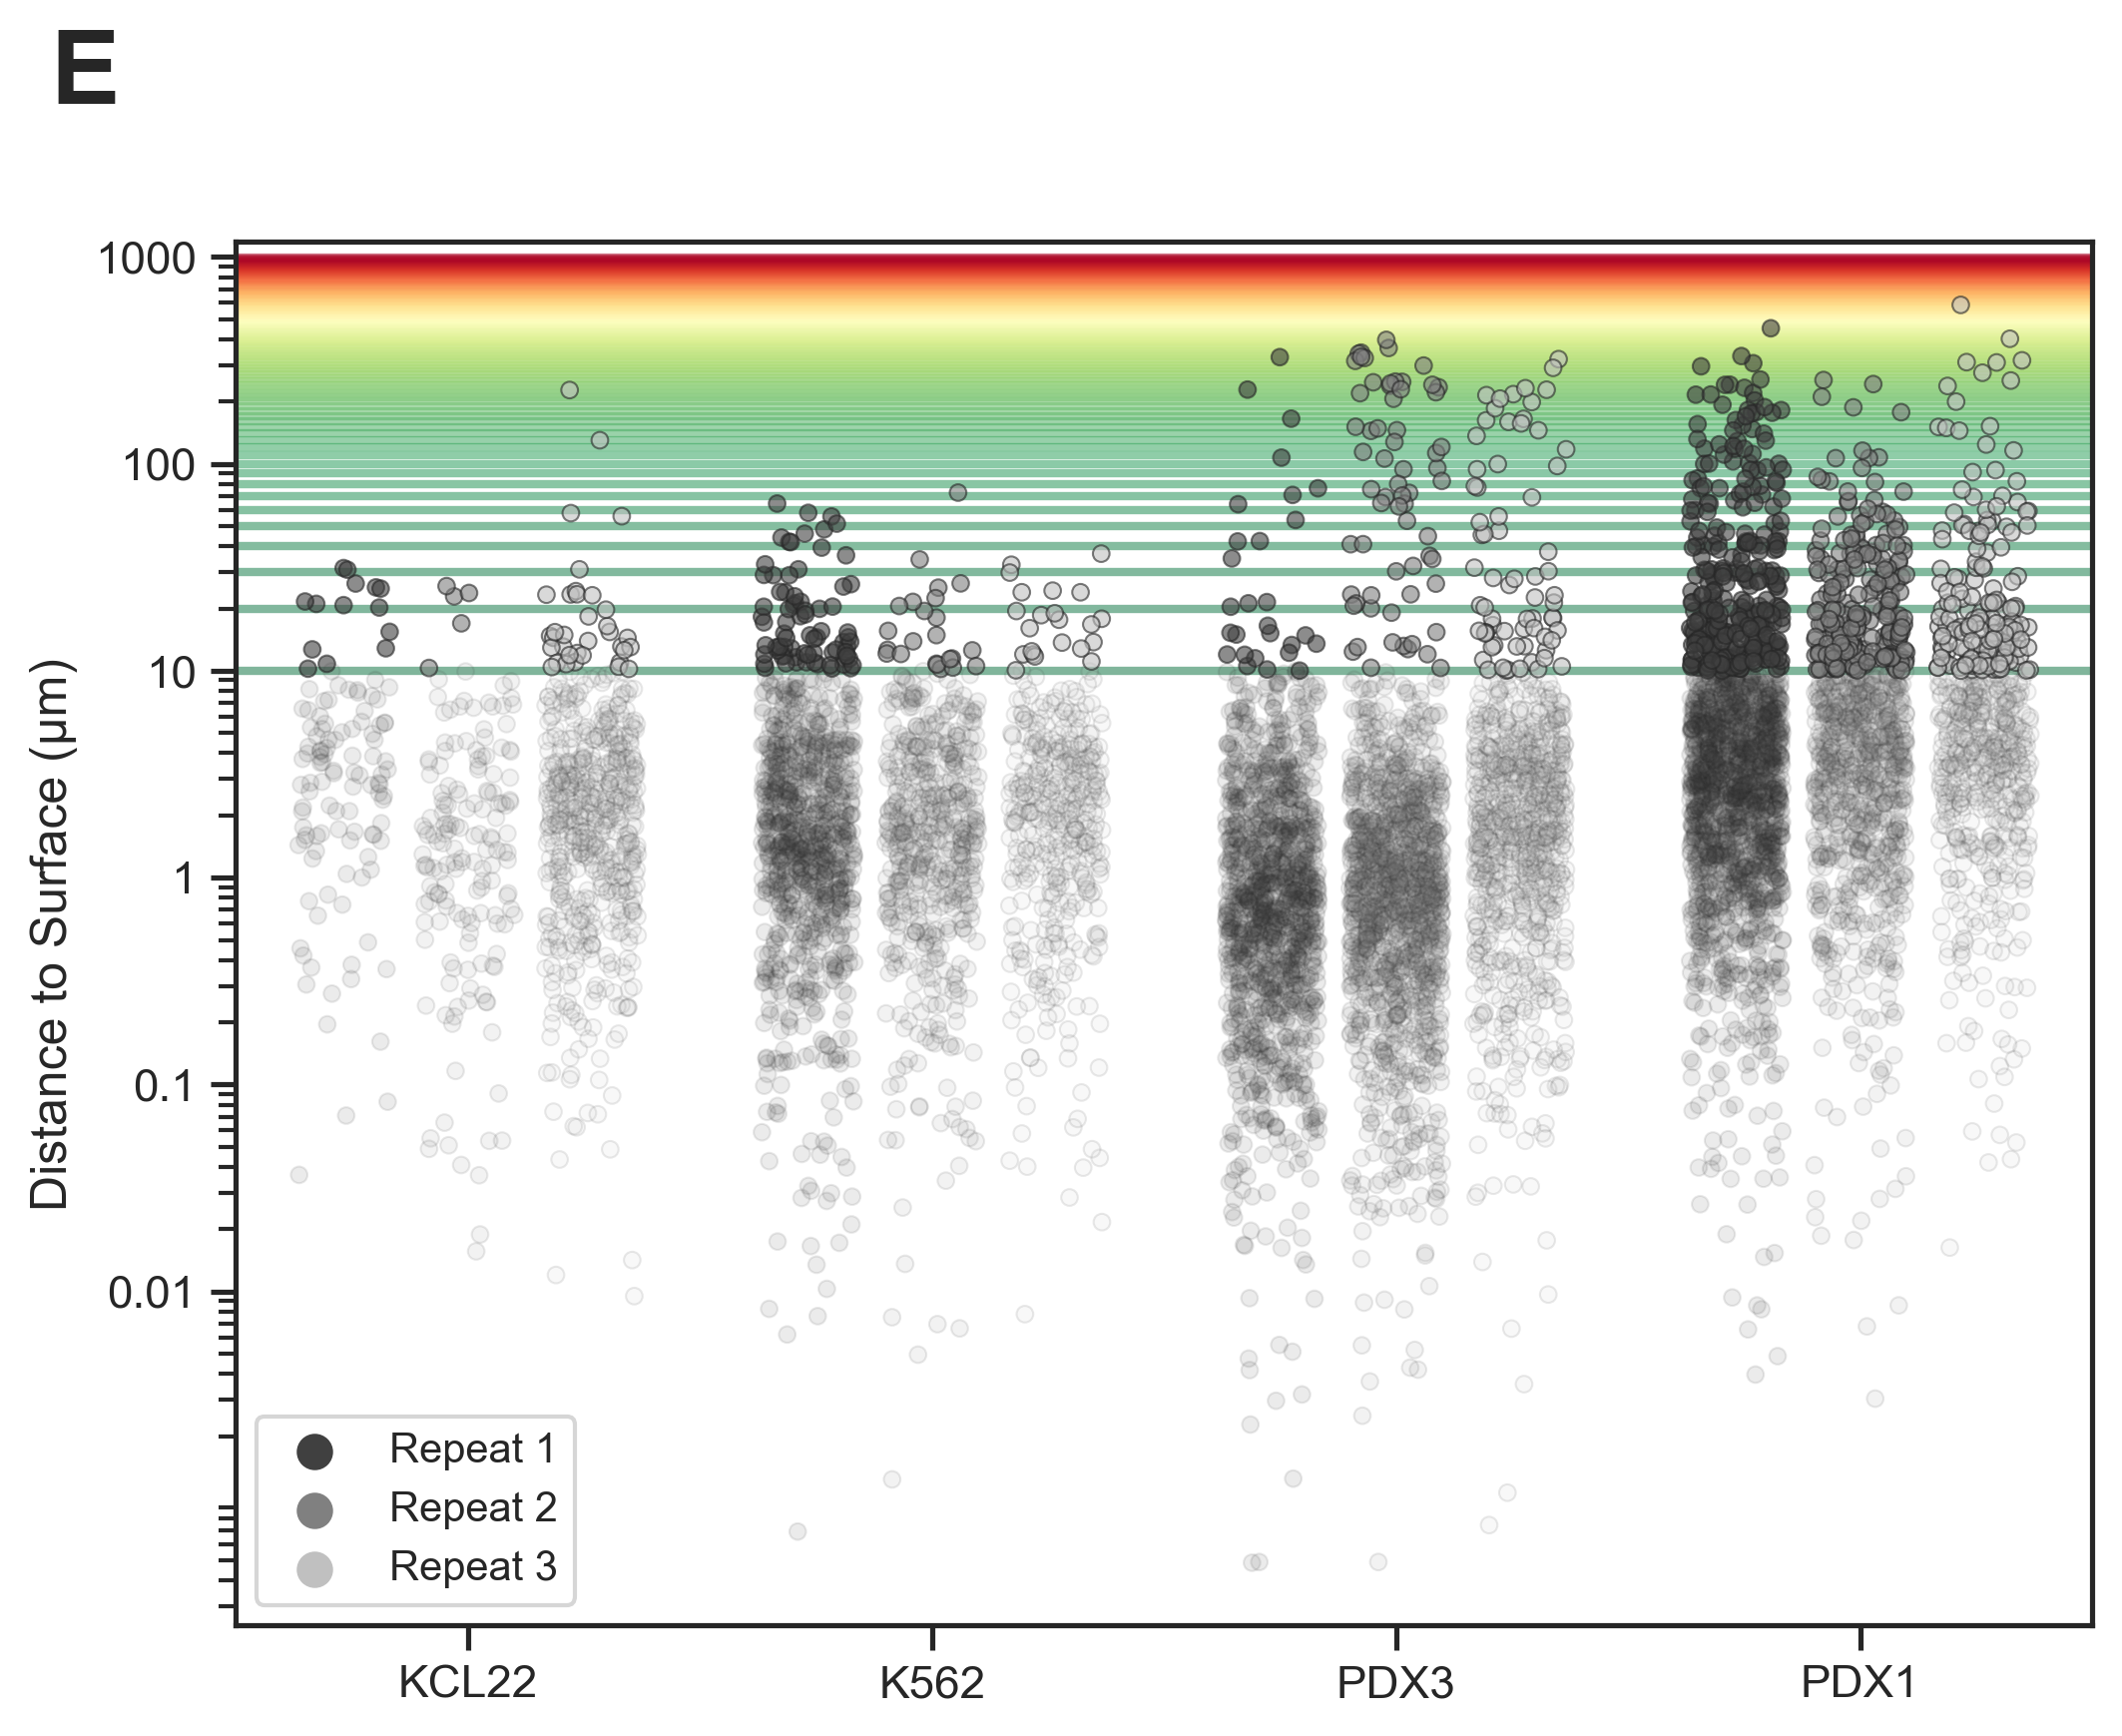

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_final is your DataFrame and it's already loaded

# Set the theme for the plots
sns.set_theme(style="ticks", palette="gray")

# Define group for subplot A (using the entire dataset)
group_A = df_final

# Calculate number of subplot rows needed
fig_height = 6  # Height of subplot A
fig, ax = plt.subplots(1, 1, figsize=(8, fig_height))

# Plot Subplot A
below_10_A = group_A[group_A["Distance to Surface (\u03BCm)"] <= 10]
above_10_A = group_A[group_A["Distance to Surface (\u03BCm)"] > 10]

# Plot for below 10
sns.stripplot(ax=ax, data=below_10_A, x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="gray", linewidth=0.5,
              size=4, alpha=0.1, jitter=.30, dodge=True)

# Plot for above 10
sns.stripplot(ax=ax, data=above_10_A, x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="gray", linewidth=0.5,
              size=4, alpha=0.6, jitter=.30, dodge=True)

# Logarithmic scale and custom ticks
ax.set_yscale("log")
ticks = [0.01, 0.1, 1, 10, 100, 1000]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)

# Background bars adjusted as per your requirement
for y in range(10, 1000, 10):
    ax.axhline(y=y, color=plt.cm.RdYlGn(1 - y / 1000), linewidth=2, alpha=0.5)

# Customize as needed
ax.set_xlabel('')  # Remove the 'Entity' label from the x-axis

# Adjust legend to only show unique items
handles, labels = ax.get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)
ax.legend(unique_handles, unique_labels, loc='best', fontsize='small')

# Annotations for subplot A
ax.annotate('E', xy=(-0.1, 1.1), xycoords="axes fraction", fontsize=25, weight='bold')

# Save and show subplot A
plt.savefig(plot_savepath('DistanceQueries_Results_3.pdf'), bbox_inches='tight')
plt.savefig(plot_savepath('DistanceQueries_Results_3.png'), dpi=300, bbox_inches='tight')
plt.show()
